In [1]:
from modules import *
from random_structures import generate_structure
import networkx as nx 
import matplotlib.pyplot as plt 

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnchoredText
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1 import make_axes_locatable

def plot_style_one():
    # Single-column Nature width ≈ 90 mm → ~3.54 in
    mpl.rcParams.update({
        "figure.dpi": 300,
        "savefig.dpi": 300,
        "figure.figsize": (4.8, 1.5),   # small, compact
        "font.size": 7,                  # 7–8 pt typical
        "axes.titlesize": 7,
        "axes.labelsize": 7,
        "xtick.labelsize": 6,
        "ytick.labelsize": 6,
        "legend.fontsize": 6,
        "axes.spines.top": False,
        "axes.spines.right": False,
        "pdf.fonttype": 42,              # editable text in Illustrator
        "ps.fonttype": 42
    })

def plot_merged(time, S_hist, network, title_left="Spike raster", title_right="Connectivity"):
    """
    Creates a two-panel figure:
      (a) spike raster (eventplot) for neurons ordered by col_order
      (b) sorted connectivity matrix with the same split boundary
    """
    plot_style_one()

    # ---- Prepare ordering by sign of outgoing max (your logic) ----
    # A = network.W.copy()
    # negative_cols = (A.max(axis=0) <= 0)
    # col_order = np.r_[np.where(~negative_cols)[0], np.where(negative_cols)[0]]
    # A_sorted = A[:, col_order]
    # split_index = int(np.sum(~negative_cols))

        # ---- Prepare ordering by neuron type (E first, then I) ----
    A = network.W.copy()

    # Build an excitatory mask from neuron metadata (True for 'E')
    exc_mask = np.array([getattr(n, "neuron_type", None) == "E" for n in network.neurons], dtype=bool)

    # Order: all E indices, then all I indices
    col_order = np.r_[np.where(exc_mask)[0], np.where(~exc_mask)[0]]
    split_index = int(exc_mask.sum())

    # Reorder BOTH axes so the matrix shows clear E/I blocks
    A_sorted = A[np.ix_(col_order, col_order)]

    # ---- Symmetric color range for diverging cmap ----
    cmax = np.abs(A_sorted).max() if A_sorted.size else 1.0

    # ---- Figure layout (slightly wider left panel) ----
    fig = plt.figure()
    gs = fig.add_gridspec(ncols=2, nrows=1, width_ratios=[1.5, .5], wspace=0.25)
    ax_raster = fig.add_subplot(gs[0,0])
    ax_mat    = fig.add_subplot(gs[0,1])
        
    # ---- (a) Raster as scatter ----
    spike_times = []
    spike_neurons = []

    for row_idx, neuron_idx in enumerate(col_order, start=1):
        spikes = time[np.asarray(S_hist)[:, neuron_idx].astype(bool)]
        spike_times.extend(spikes)
        spike_neurons.extend([row_idx] * len(spikes))

    ax_raster.scatter(
        spike_times,
        spike_neurons,
        s=0.1,                     # marker size in points^2
        c='k',                    # black
        marker='o',               # 'o' for circles, 's' for squares
        linewidths=0
    )

    ax_raster.set_xlabel('Time (ms)')
    ax_raster.set_ylabel('Neuron ID')
    ax_raster.set_ylim(0.5, network.N + 0.5)
    ax_raster.axhline(split_index + 0.5, color='k', lw=0.4)
    ax_raster.set_title(title_left, pad=2)

    # ---- (b) Sorted adjacency matrix ----
    im = ax_mat.imshow(A_sorted, vmin=-cmax, vmax=cmax, cmap='RdBu_r', aspect='auto', interpolation='nearest')
    # after im = ax_mat.imshow(...)
    ax_mat.axvline(split_index - 0.5, color='k', lw=0.4)
    ax_mat.axhline(split_index - 0.5, color='k', lw=0.4)  # add this
    ax_mat.set_xlabel('Presynaptic neuron')
    ax_mat.set_ylabel('Postsynaptic neuron')
    ax_mat.tick_params(length=2)

    ax_mat.set_title(title_right, pad=2)

    # Compact colorbar as an inset to the right panel
    divider = make_axes_locatable(ax_mat)
    cax = divider.append_axes("right", size="5%", pad=0.05)  # pad in inches

    cb = fig.colorbar(im, cax=cax)
    cb.ax.tick_params(labelsize=6, length=2)

    #     # For raster plot (above/below horizontal split)
    # ax_raster.text(- 20, split_index + 5, 'I',
    #             ha='center', va='bottom', fontsize=7, fontweight='bold')
    # ax_raster.text(-20, split_index - 10, 'E',
    #             ha='center', va='top', fontsize=7, fontweight='bold')

    # # For connectivity matrix (left/right of vertical split)
    # ax_mat.text(split_index-70, +50, 'E',
    #             ha='center', va='bottom', fontsize=7, fontweight='bold')
    # ax_mat.text(split_index + (A_sorted.shape[1]-split_index)/2, +50, 'I',
    #             ha='center', va='bottom', fontsize=7, fontweight='bold')
    #     #fig.tight_layout()
    # Raster labels on y-axis
    ax_raster.text(ax_raster.get_xlim()[0], split_index + 2, 'I', ha='left', va='bottom', fontsize=7, fontweight='bold')
    ax_raster.text(ax_raster.get_xlim()[0], split_index - 2, 'E', ha='left', va='top', fontsize=7, fontweight='bold')

    # Matrix labels centered in each block
    #n = A_sorted.shape[0]
    #ax_mat.text(split_index/2,           2, 'E', ha='center', va='bottom', fontsize=7, fontweight='bold')
    #ax_mat.text((split_index+n)/2,       2, 'I', ha='center', va='bottom', fontsize=7, fontweight='bold')

    return fig, (ax_raster, ax_mat)



def plot_degree_distributions(G, figsize=(3, 1)):
    """
    Plot in-degree and out-degree distributions for a directed graph.

    Parameters
    ----------
    G : networkx.DiGraph
        The directed graph to analyze.
    figsize : tuple
        Figure size in inches, default is (6, 3).
    """
    plot_style_one()

    # Extract in-degree and out-degree sequences
    in_degrees = [d for _, d in G.in_degree()]
    out_degrees = [d for _, d in G.out_degree()]

    # Create subplots for histograms
    fig, axes = plt.subplots(1, 2, figsize=figsize)

    # In-degree histogram
    axes[0].hist(in_degrees, bins=range(min(in_degrees), max(in_degrees) + 2),
                 align='left', rwidth=0.8)
    axes[0].set_xlabel("In-Degree")
    axes[0].set_ylabel("# Nodes")
    axes[0].set_title("In-Degree Distribution")
    axes[0].grid(axis='y', linestyle='--', alpha=0.7)

    # Out-degree histogram
    axes[1].hist(out_degrees, bins=range(min(out_degrees), max(out_degrees) + 2),
                 align='left', rwidth=0.8, color='orange')
    axes[1].set_xlabel("Out-Degree")
    axes[1].set_ylabel("# Nodes")
    axes[1].set_title("Out-Degree Distribution")
    axes[1].grid(axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()

def get_neuron_order(network):
    """Returns col_order, split_index, and sorted adjacency matrix based on E/I ordering."""
    A = network.W.copy()
    exc_mask = np.array(
        [getattr(n, "neuron_type", None) == "E" for n in network.neurons],
        dtype=bool
    )
    col_order = np.r_[np.where(exc_mask)[0], np.where(~exc_mask)[0]]
    split_index = int(exc_mask.sum())
    A_sorted = A[np.ix_(col_order, col_order)]
    return col_order, split_index, A_sorted
def plot_connectivity_matrix(network, title="Connectivity"):
    col_order, split_index, A_sorted = get_neuron_order(network)
    cmax = np.abs(A_sorted).max() if A_sorted.size else 1.0

    fig, ax = plt.subplots(figsize=(2,2))
    im = ax.imshow(A_sorted, vmin=-cmax, vmax=cmax, cmap='RdBu_r', aspect='auto', interpolation='nearest')
    ax.axvline(split_index - 0.5, color='k', lw=0.4)
    ax.axhline(split_index - 0.5, color='k', lw=0.4)
    ax.set_xlabel('Presynaptic neuron')
    ax.set_ylabel('Postsynaptic neuron')
    ax.tick_params(length=2)
    ax.set_title(title, pad=2)

    # Colorbar
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cb = fig.colorbar(im, cax=cax)
    cb.ax.tick_params(labelsize=6, length=2)

    return fig, ax



# ER Sparse

/Users/mauffee/Projects/resinets/resilient_networks/src/modules.py:163: RuntimeWarning: divide by zero encountered in matmul
  I_syn = self.W @ self._last_spike
/Users/mauffee/Projects/resinets/resilient_networks/src/modules.py:163: RuntimeWarning: overflow encountered in matmul
  I_syn = self.W @ self._last_spike
/Users/mauffee/Projects/resinets/resilient_networks/src/modules.py:163: RuntimeWarning: invalid value encountered in matmul
  I_syn = self.W @ self._last_spike


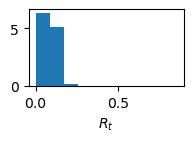

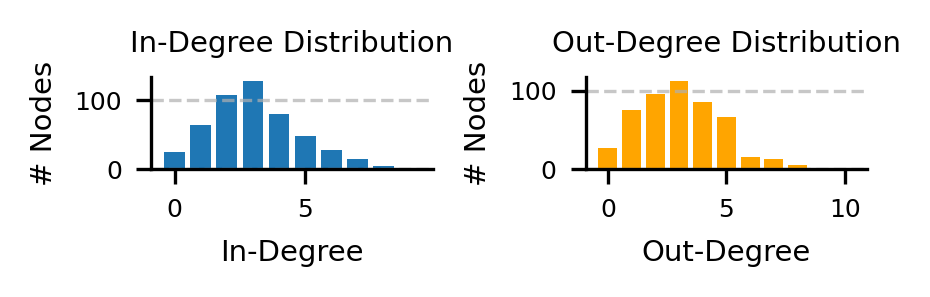

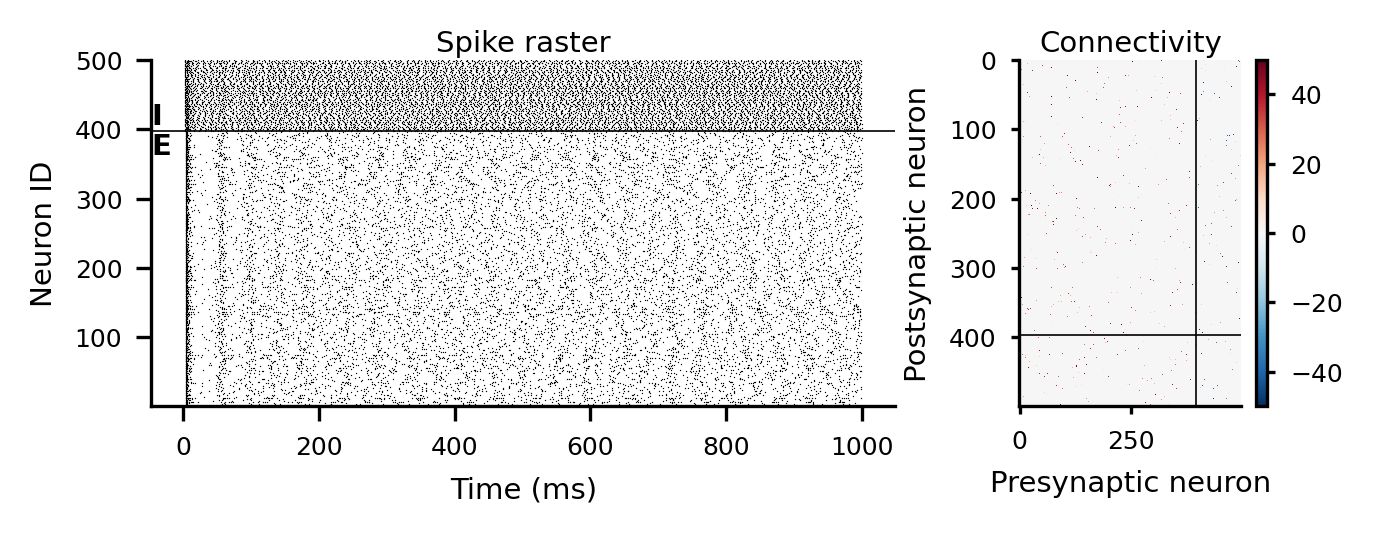

In [3]:
params = {
    'N': 500,
    'attack_percentage': 0.1,
    'graph_type':  'ER',#'SF',
    'graph_category': 'sparse', #'sparse','balanced'
    'sim_time': 1000,
    'parent_seed':472,
    'fraction_em': 0.33,
    'base_current': 10,
    'weight_bounds': (1., 50.),
    'weight_base': 50,
    'n_attacks': 10,
    'use_plastic': False,
}

N = params['N']
attack_percentage = params['attack_percentage']
graph_type = params['graph_type']
graph_category = params['graph_category']
sim_time = params['sim_time']
parent_seed = params['parent_seed']
fraction_em = params['fraction_em']
base_current = params['base_current']
weight_bounds = params['weight_bounds']
weight_base = params['weight_base']
n_attacks = params['n_attacks']

use_plastic = params['use_plastic']
rng = np.random.default_rng(parent_seed)
structure_seed = rng.integers(0, 2**32)
attack_seed = rng.integers(0, 2**32)

G, params = generate_structure(graph_type, N, structure_seed,  category=graph_category)


#network, neurons = create_network_normalised(G, structure_seed, base_strength=weight_base ,sim_time=sim_time, plastic=use_plastic)
network, neurons = create_network(G, structure_seed, weight_bounds=weight_bounds ,sim_time=sim_time, plastic=use_plastic)

I_ext =  create_input(int(network.steps*2), N, base_current, rng=rng)
time, V_hist, S_hist = network.run(I_ext[network.steps:])

fig, ax = plt.subplots(figsize=(2,1))
plt.hist(network.R_t, density=True)
plt.xlabel(r'$R_t$')
plt.show()

plot_degree_distributions(network.G)
# Example usage (keeps your logic, just merged cleanly):
fig, axes = plot_merged(time, S_hist, network)
# fig.savefig("figure_s1.svg")  # or .pdf/.png
plt.show()

# ER Intermediate

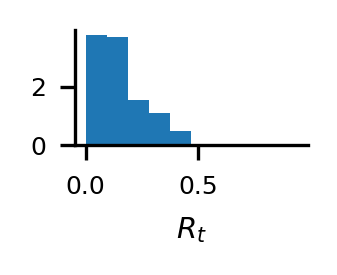

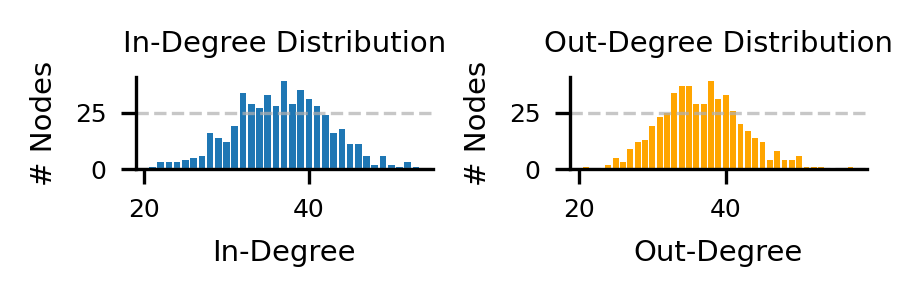

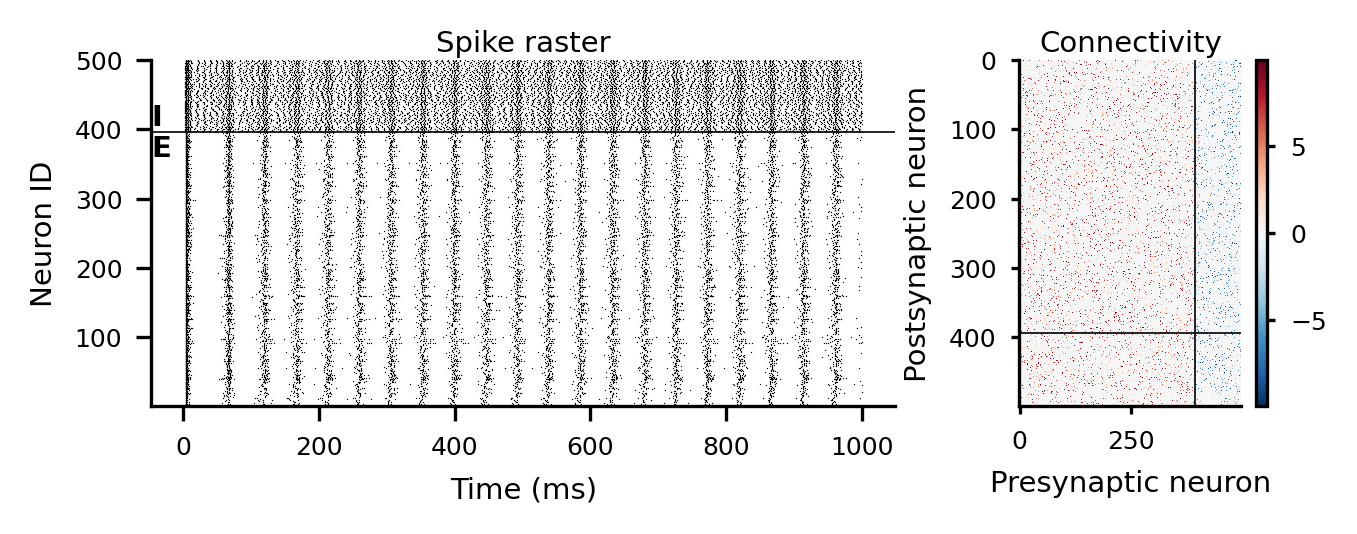

In [4]:
params = {
    'N': 500,
    'attack_percentage': 0.1,
    'graph_type':  'ER',#'SF',
    'graph_category': 'intermediate', #'sparse','balanced'
    'sim_time': 1000,
    'parent_seed':42,
    'fraction_em': 0.33,
    'base_current': 10,
    'weight_bounds': (1., 10.),
    'weight_base': 50,
    'n_attacks': 10,
    'use_plastic': False,
}

N = params['N']
attack_percentage = params['attack_percentage']
graph_type = params['graph_type']
graph_category = params['graph_category']
sim_time = params['sim_time']
parent_seed = params['parent_seed']
fraction_em = params['fraction_em']
base_current = params['base_current']
weight_bounds = params['weight_bounds']
weight_base = params['weight_base']
n_attacks = params['n_attacks']

use_plastic = params['use_plastic']
rng = np.random.default_rng(parent_seed)
structure_seed = rng.integers(0, 2**32)
attack_seed = rng.integers(0, 2**32)


G, params = generate_structure(graph_type, N, structure_seed,  category=graph_category)


#network, neurons = create_network_normalised(G, structure_seed, base_strength=weight_base ,sim_time=sim_time, plastic=use_plastic)
network, neurons = create_network(G, structure_seed, weight_bounds=weight_bounds ,sim_time=sim_time, plastic=use_plastic)
I_ext =  create_input(int(network.steps*2), N, base_current, rng=rng)
time, V_hist, S_hist = network.run(I_ext[network.steps:])

fig, ax = plt.subplots(figsize=(1,0.5))
plt.hist(network.R_t, density=True)
plt.xlabel(r'$R_t$')
plt.show()

plot_degree_distributions(network.G)
# Example usage (keeps your logic, just merged cleanly):
fig, axes = plot_merged(time, S_hist, network)
# fig.savefig("figure_s1.svg")  # or .pdf/.png
plt.show()

# ER Dense

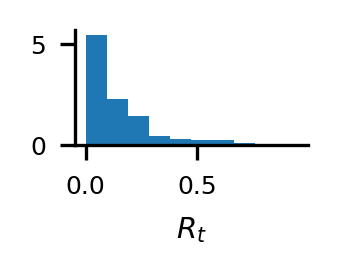

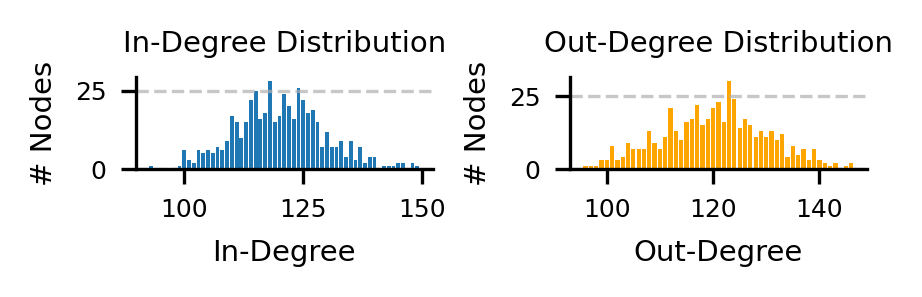

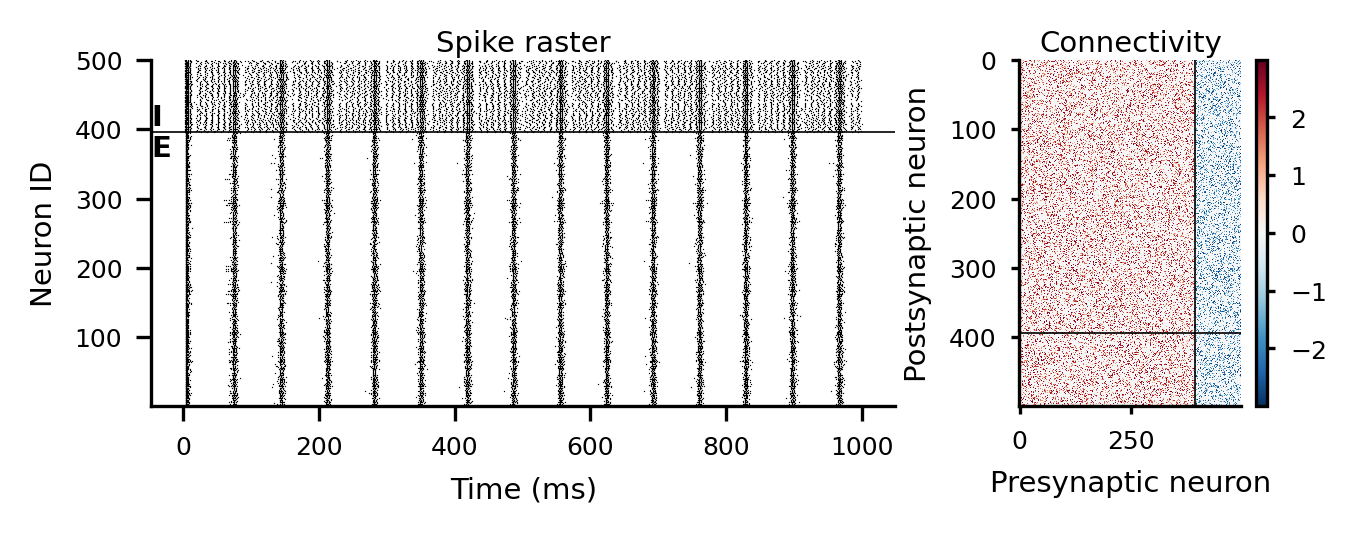

In [5]:
params = {
    'N': 500,
    'attack_percentage': 0.1,
    'graph_type':  'ER',#'SF',
    'graph_category': 'dense', #'sparse','balanced'
    'sim_time': 1000,
    'parent_seed':42,
    'fraction_em': 0.33,
    'base_current': 10,
    'weight_bounds': (1., 3.),
    'weight_base': 10,
    'n_attacks': 10,
    'use_plastic': False,
}

N = params['N']
attack_percentage = params['attack_percentage']
graph_type = params['graph_type']
graph_category = params['graph_category']
sim_time = params['sim_time']
parent_seed = params['parent_seed']
fraction_em = params['fraction_em']
base_current = params['base_current']
weight_bounds = params['weight_bounds']
weight_base = params['weight_base']
n_attacks = params['n_attacks']

use_plastic = params['use_plastic']
rng = np.random.default_rng(parent_seed)
structure_seed = rng.integers(0, 2**32)
attack_seed = rng.integers(0, 2**32)

G, params = generate_structure(graph_type, N, structure_seed,  category=graph_category)


#network, neurons = create_network_normalised(G, structure_seed, base_strength=weight_base ,sim_time=sim_time, plastic=use_plastic)
network, neurons = create_network(G, structure_seed, weight_bounds=weight_bounds ,sim_time=sim_time, plastic=use_plastic)

I_ext =  create_input(int(network.steps*2), N, base_current, rng=rng)
time, V_hist, S_hist = network.run(I_ext[network.steps:])

fig, ax = plt.subplots(figsize=(1,0.5))
plt.hist(network.R_t, density=True)
plt.xlabel(r'$R_t$')
plt.show()

plot_degree_distributions(network.G)
# Example usage (keeps your logic, just merged cleanly):
fig, axes = plot_merged(time, S_hist, network)
# fig.savefig("figure_s1.svg")  # or .pdf/.png
plt.show()

# SF receiver

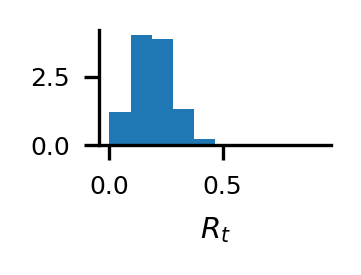

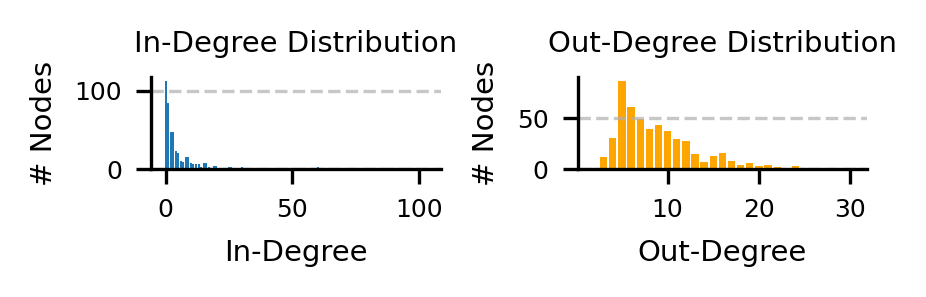

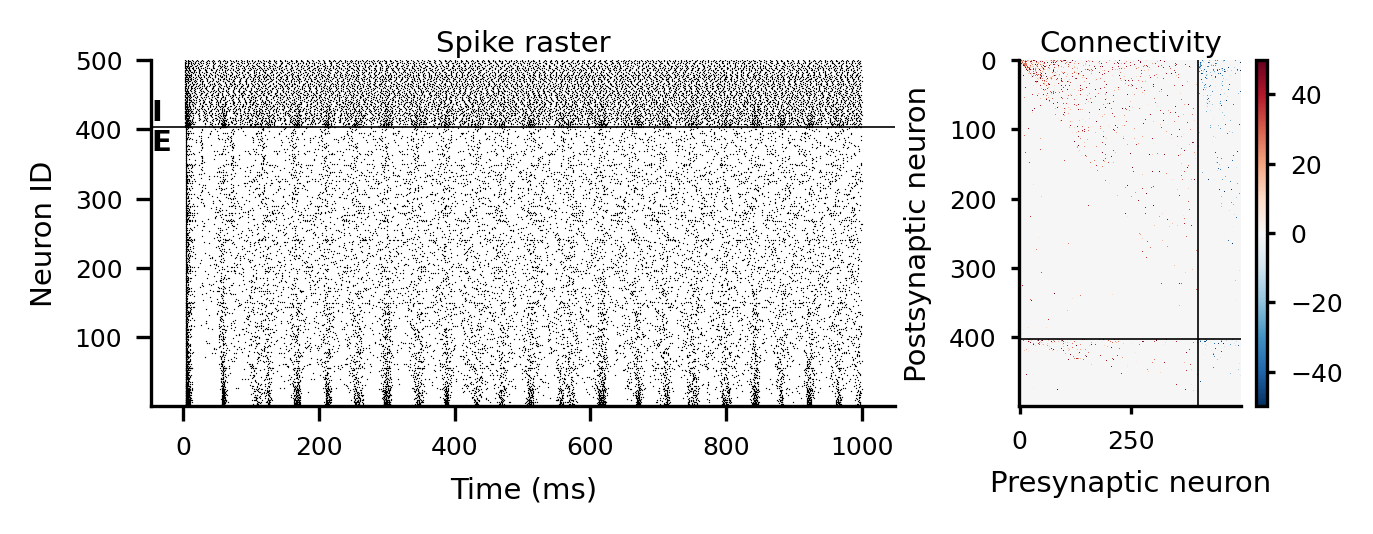

In [6]:
params = {
    'N': 500,
    'attack_percentage': 0.1,
    'graph_type':  'SF',#'SF',
    'graph_category': 'receiver', #'broadcaster', 'balanced'
    'sim_time': 1000,
    'parent_seed':34332,
    'fraction_em': 0.33,
    'base_current': 10,
    'weight_bounds': (1., 50.),
    'weight_base': 10,
    'n_attacks': 10,
    'use_plastic': False,
}

N = params['N']
attack_percentage = params['attack_percentage']
graph_type = params['graph_type']
graph_category = params['graph_category']
sim_time = params['sim_time']
parent_seed = params['parent_seed']
fraction_em = params['fraction_em']
base_current = params['base_current']
weight_bounds = params['weight_bounds']
weight_base = params['weight_base']
n_attacks = params['n_attacks']

use_plastic = params['use_plastic']
rng = np.random.default_rng(parent_seed)
structure_seed = rng.integers(0, 2**32)
attack_seed = rng.integers(0, 2**32)

G, params = generate_structure(graph_type, N, structure_seed,  category=graph_category)


#network, neurons = create_network_normalised(G, structure_seed, base_strength=weight_base ,sim_time=sim_time, plastic=use_plastic)
network, neurons = create_network(G, structure_seed, weight_bounds=weight_bounds ,sim_time=sim_time, plastic=use_plastic)

I_ext =  create_input(int(network.steps*2), N, base_current, rng=rng)
time, V_hist, S_hist = network.run(I_ext[network.steps:])

fig, ax = plt.subplots(figsize=(1,0.5))
plt.hist(network.R_t, density=True)
plt.xlabel(r'$R_t$')
plt.show()

plot_degree_distributions(network.G)
# Example usage (keeps your logic, just merged cleanly):
fig, axes = plot_merged(time, S_hist, network)
# fig.savefig("figure_s1.svg")  # or .pdf/.png
plt.show()

# SF broadcaster

/Users/mauffee/Projects/resinets/resilient_networks/src/modules.py:163: RuntimeWarning: divide by zero encountered in matmul
  I_syn = self.W @ self._last_spike
/Users/mauffee/Projects/resinets/resilient_networks/src/modules.py:163: RuntimeWarning: overflow encountered in matmul
  I_syn = self.W @ self._last_spike
/Users/mauffee/Projects/resinets/resilient_networks/src/modules.py:163: RuntimeWarning: invalid value encountered in matmul
  I_syn = self.W @ self._last_spike


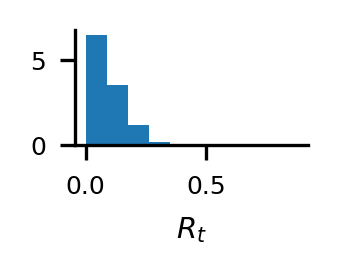

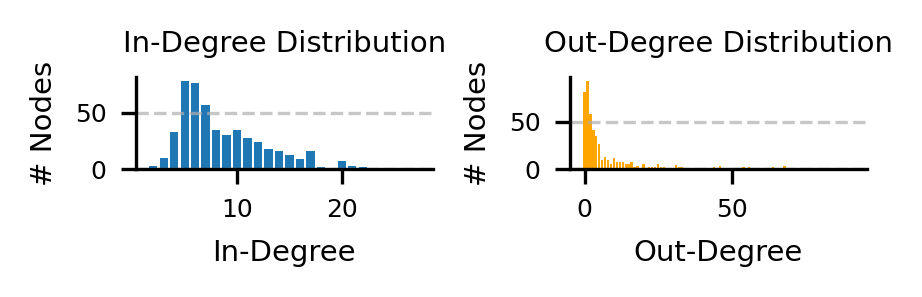

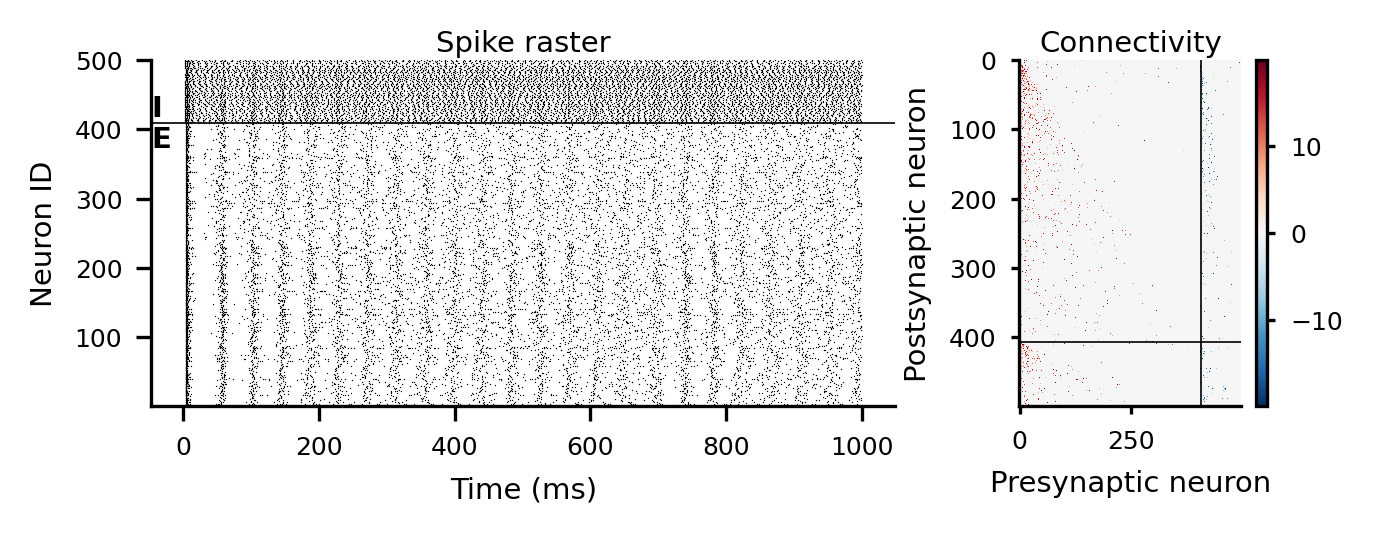

In [10]:
params = {
    'N': 500,
    'attack_percentage': 0.1,
    'graph_type':  'SF',#'SF',
    'graph_category': 'broadcaster', #'broadcaster', 'balanced'
    'sim_time': 1000,
    'parent_seed':1577870015,
    'fraction_em': 0.33,
    'base_current': 10,
    'weight_bounds': (1., 20.),
    'weight_base': 10,
    'n_attacks': 10,
    'use_plastic': False,
}

N = params['N']
attack_percentage = params['attack_percentage']
graph_type = params['graph_type']
graph_category = params['graph_category']
sim_time = params['sim_time']
parent_seed = params['parent_seed']
fraction_em = params['fraction_em']
base_current = params['base_current']
weight_bounds = params['weight_bounds']
weight_base = params['weight_base']
n_attacks = params['n_attacks']

use_plastic = params['use_plastic']
rng = np.random.default_rng(parent_seed)
structure_seed = rng.integers(0, 2**32)
attack_seed = rng.integers(0, 2**32)

G, params = generate_structure(graph_type, N, structure_seed,  category=graph_category)


#network, neurons = create_network_normalised(G, structure_seed, base_strength=weight_base ,sim_time=sim_time, plastic=use_plastic)
network, neurons = create_network(G, structure_seed, weight_bounds=weight_bounds ,sim_time=sim_time, plastic=use_plastic)

I_ext =  create_input(int(network.steps*2), N, base_current, rng=rng)
time, V_hist, S_hist = network.run(I_ext[network.steps:])

fig, ax = plt.subplots(figsize=(1,0.5))
plt.hist(network.R_t, density=True)
plt.xlabel(r'$R_t$')
plt.show()

plot_degree_distributions(network.G)
# Example usage (keeps your logic, just merged cleanly):
fig, axes = plot_merged(time, S_hist, network)
# fig.savefig("figure_s1.svg")  # or .pdf/.png
plt.show()

# SF balanced

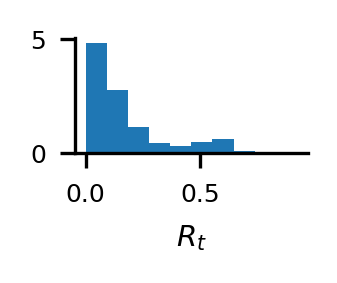

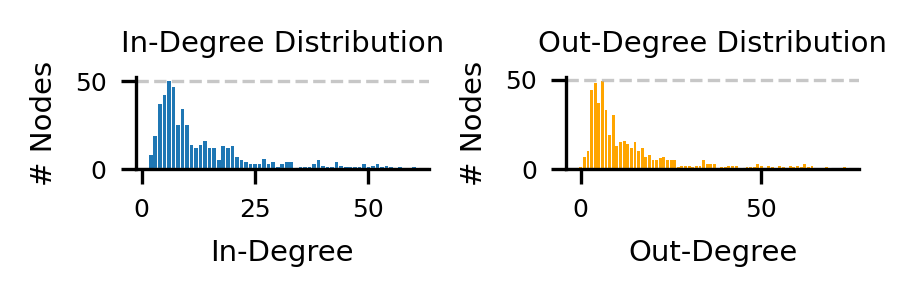

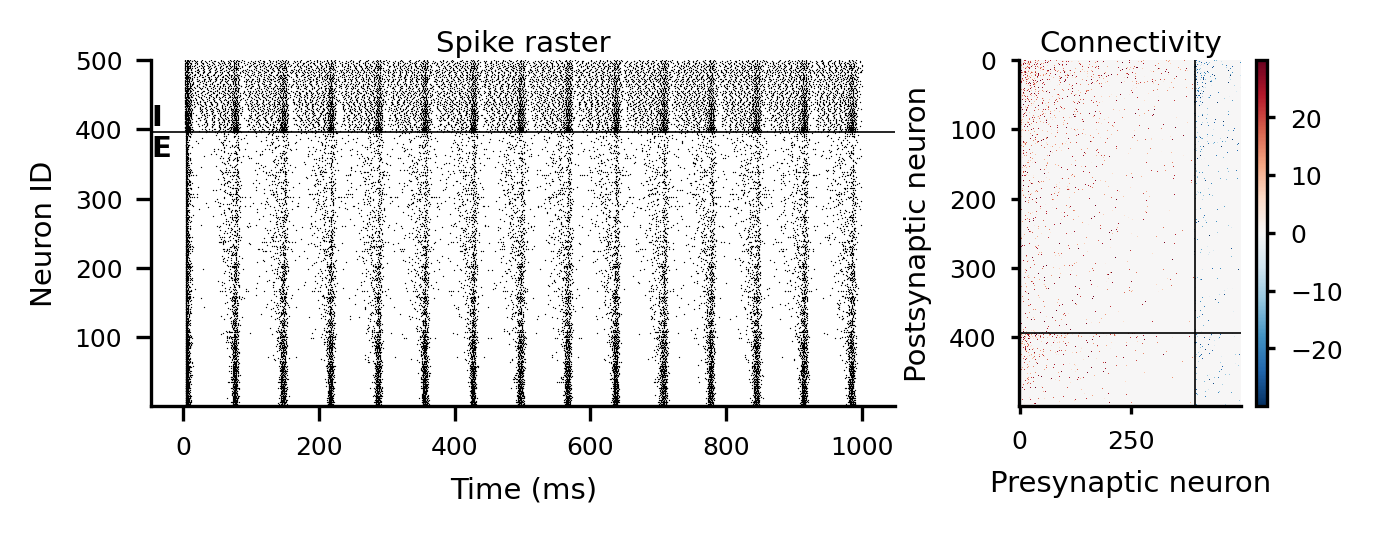

In [8]:
params = {
    'N': 500,
    'attack_percentage': 0.1,
    'graph_type':  'SF',#'SF',
    'graph_category': 'balanced', #'broadcaster', 'balanced'
    'sim_time': 1000,
    'parent_seed':42,
    'fraction_em': 0.33,
    'base_current': 10,
    'weight_bounds': (1., 30.),
    'weight_base': 10,
    'n_attacks': 10,
    'use_plastic': False,
}

N = params['N']
attack_percentage = params['attack_percentage']
graph_type = params['graph_type']
graph_category = params['graph_category']
sim_time = params['sim_time']
parent_seed = params['parent_seed']
fraction_em = params['fraction_em']
base_current = params['base_current']
weight_bounds = params['weight_bounds']
weight_base = params['weight_base']
n_attacks = params['n_attacks']

use_plastic = params['use_plastic']
rng = np.random.default_rng(parent_seed)
structure_seed = rng.integers(0, 2**32)
attack_seed = rng.integers(0, 2**32)

G, params = generate_structure(graph_type, N, structure_seed,  category=graph_category)


#network, neurons = create_network_normalised(G, structure_seed, base_strength=weight_base ,sim_time=sim_time, plastic=use_plastic)
network, neurons = create_network(G, structure_seed, weight_bounds=weight_bounds ,sim_time=sim_time, plastic=use_plastic)

I_ext =  create_input(int(network.steps*2), N, base_current, rng=rng)
time, V_hist, S_hist = network.run(I_ext[network.steps:])

fig, ax = plt.subplots(figsize=(1,0.5))
plt.hist(network.R_t, density=True)
plt.xlabel(r'$R_t$')
plt.show()

plot_degree_distributions(network.G)
# Example usage (keeps your logic, just merged cleanly):
fig, axes = plot_merged(time, S_hist, network)
# fig.savefig("figure_s1.svg")  # or .pdf/.png
plt.show()

# SBM assortative

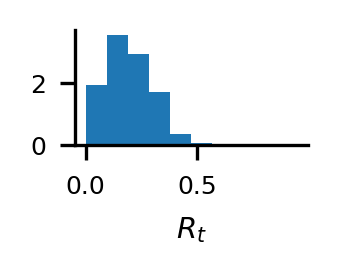

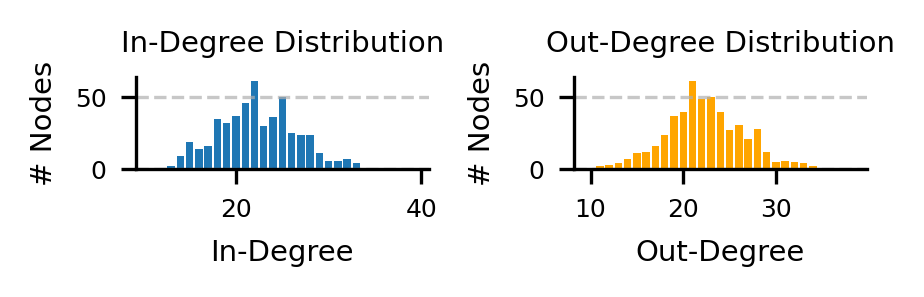

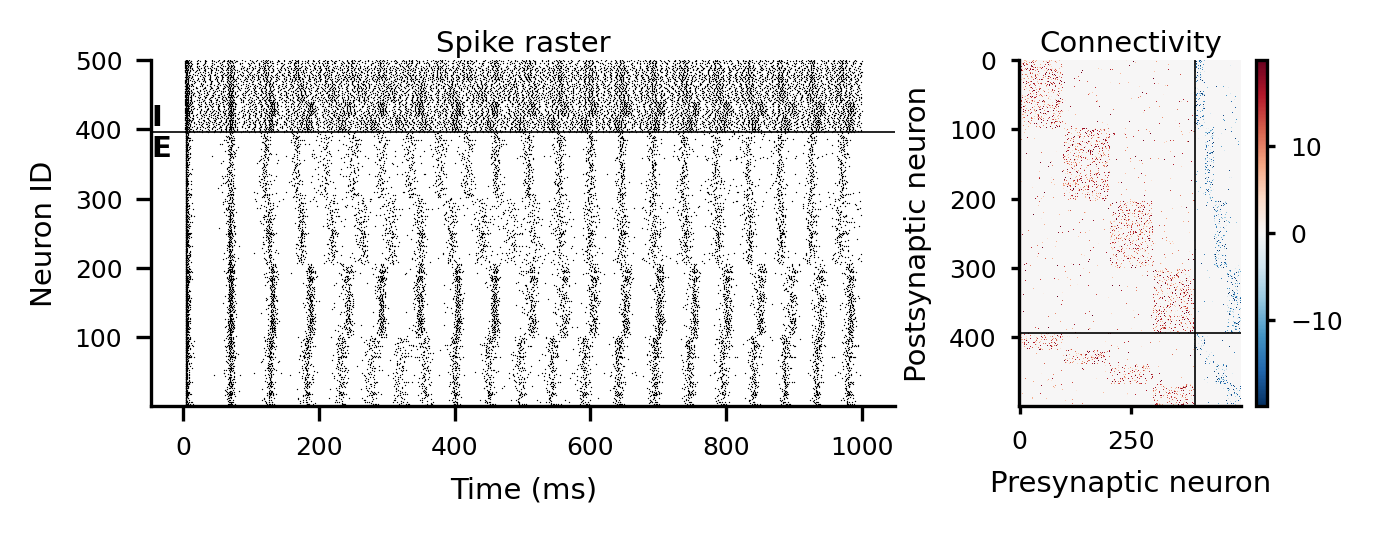

In [10]:
params = {
    'N': 500,
    'attack_percentage': 0.1,
    'graph_type':  'SBM',#'SF',
    'graph_category': 'assortative', #'broadcaster', 'balanced'
    'sim_time': 1000,
    'parent_seed':42,
    'fraction_em': 0.33,
    'base_current': 10,
    'weight_bounds': (1., 20.),
    'weight_base': 10,
    'n_attacks': 10,
    'use_plastic': False,
}

N = params['N']
attack_percentage = params['attack_percentage']
graph_type = params['graph_type']
graph_category = params['graph_category']
sim_time = params['sim_time']
parent_seed = params['parent_seed']
fraction_em = params['fraction_em']
base_current = params['base_current']
weight_bounds = params['weight_bounds']
weight_base = params['weight_base']
n_attacks = params['n_attacks']

use_plastic = params['use_plastic']
rng = np.random.default_rng(parent_seed)
structure_seed = rng.integers(0, 2**32)
attack_seed = rng.integers(0, 2**32)

G, params = generate_structure(graph_type, N, structure_seed,  category=graph_category)


#network, neurons = create_network_normalised(G, structure_seed, base_strength=weight_base ,sim_time=sim_time, plastic=use_plastic)
network, neurons = create_network(G, structure_seed, weight_bounds=weight_bounds ,sim_time=sim_time, plastic=use_plastic)

I_ext =  create_input(int(network.steps*2), N, base_current, rng=rng)
time, V_hist, S_hist = network.run(I_ext[network.steps:])

fig, ax = plt.subplots(figsize=(1,0.5))
plt.hist(network.R_t, density=True)
plt.xlabel(r'$R_t$')
plt.show()

plot_degree_distributions(network.G)
# Example usage (keeps your logic, just merged cleanly):
fig, axes = plot_merged(time, S_hist, network)
# fig.savefig("figure_s1.svg")  # or .pdf/.png
plt.show()

# SBM disassortative


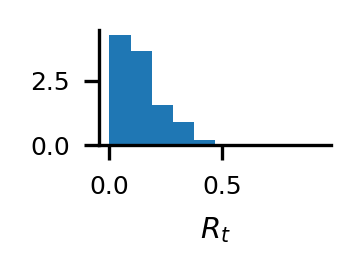

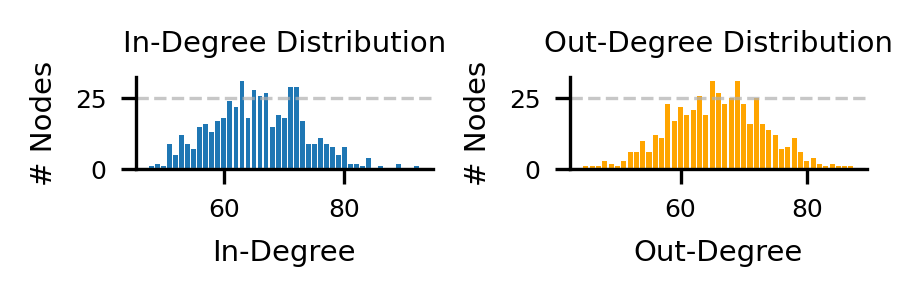

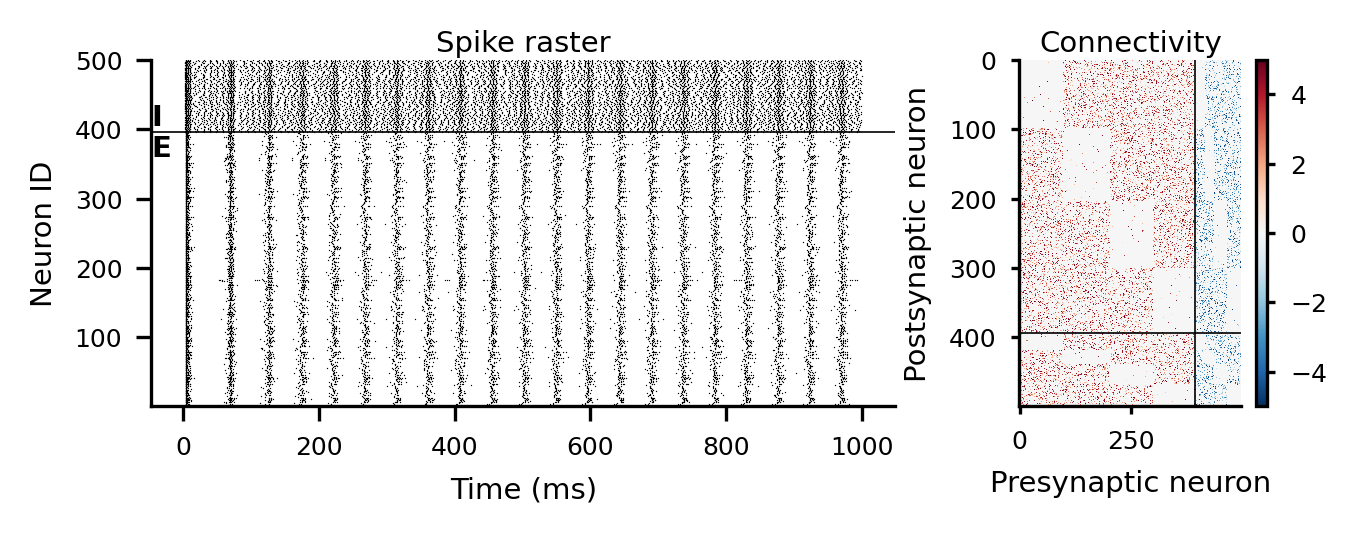

In [11]:
params = {
    'N': 500,
    'attack_percentage': 0.1,
    'graph_type':  'SBM',#'SF',
    'graph_category': 'disassortative', #'broadcaster', 'balanced'
    'sim_time': 1000,
    'parent_seed':42,
    'fraction_em': 0.33,
    'base_current': 10,
    'weight_bounds': (1., 5.),
    'weight_base': 10,
    'n_attacks': 10,
    'use_plastic': False,
}

N = params['N']
attack_percentage = params['attack_percentage']
graph_type = params['graph_type']
graph_category = params['graph_category']
sim_time = params['sim_time']
parent_seed = params['parent_seed']
fraction_em = params['fraction_em']
base_current = params['base_current']
weight_bounds = params['weight_bounds']
weight_base = params['weight_base']
n_attacks = params['n_attacks']

use_plastic = params['use_plastic']
rng = np.random.default_rng(parent_seed)
structure_seed = rng.integers(0, 2**32)
attack_seed = rng.integers(0, 2**32)

G, params = generate_structure(graph_type, N, structure_seed,  category=graph_category)


#network, neurons = create_network_normalised(G, structure_seed, base_strength=weight_base ,sim_time=sim_time, plastic=use_plastic)
network, neurons = create_network(G, structure_seed, weight_bounds=weight_bounds ,sim_time=sim_time, plastic=use_plastic)

I_ext =  create_input(int(network.steps*2), N, base_current, rng=rng)
time, V_hist, S_hist = network.run(I_ext[network.steps:])

fig, ax = plt.subplots(figsize=(1,0.5))
plt.hist(network.R_t, density=True)
plt.xlabel(r'$R_t$')
plt.show()

plot_degree_distributions(network.G)
# Example usage (keeps your logic, just merged cleanly):
fig, axes = plot_merged(time, S_hist, network)
# fig.savefig("figure_s1.svg")  # or .pdf/.png
plt.show()

In [ ]:
degrees = [d for n, d in G.in_degree()]
import powerlaw

fit = powerlaw.Fit(degrees, discrete=True)
print(f"Alpha (exponent): {fit.power_law.alpha}")
print(f"Xmin (cutoff): {fit.power_law.xmin}")
R, p = fit.distribution_compare('power_law', 'exponential')
print(f"Log-likelihood ratio: {R}, p-value: {p}")


NameError: name 'H_mixed' is not defined

In [ ]:
structures_weight_bounds = {
{'graph_type':  'ER', 'graph_category': 'sparse', 'weight_bounds': (1., 50.)},
{'graph_type':  'ER', 'graph_category': 'intermediate', 'weight_bounds': (1., 10.)},
{'graph_type':  'ER', 'graph_category': 'dense', 'weight_bounds':  (1., 3.)},
{'graph_type':  'SF', 'graph_category': 'receiver', 'weight_bounds':  (1., 50.)},
{'graph_type':  'SF', 'graph_category': 'broadcaster', 'weight_bounds': (1., 20.)},
{'graph_type':  'SF', 'graph_category': 'balanced', 'weight_bounds':  (1., 30.)},
{'graph_type':  'SBM', 'graph_category': 'assortative', 'weight_bounds':   (1., 20.)},
{'graph_type':  'SBM', 'graph_category': 'disassortative', 'weight_bounds':  (1., 5.)}
}




In [72]:
import networkx as nx 
import matplotlib.pyplot as plt 

G = nx.extended_barabasi_albert_graph(200, 4, p=0.2, q=0.2)

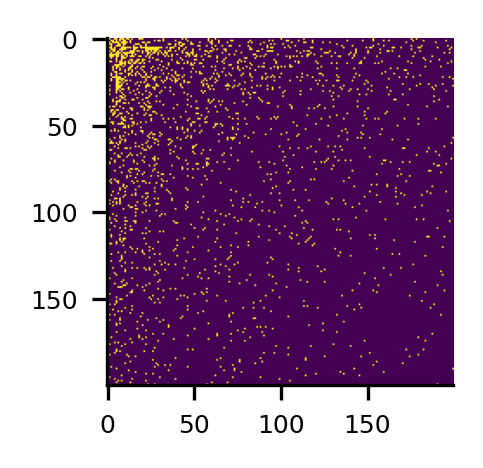

In [73]:
plt.imshow(nx.to_numpy_array(G).T)